Extract mel-spectrogram from audio

In [1]:
import numpy as np
import os
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import concatenate
import matplotlib.pyplot as plt


Find graphic specs

In [2]:
def load_data(dir_path):
   X = []
   y = []
   labels = ['PD', 'HC']
   for label in labels:
      path = os.path.join(dir_path, label)
      class_num = labels.index(label)
      for img in os.listdir(path):
         try:
               img_arr = img_to_array(load_img(os.path.join(path, img), target_size=(640, 480)))  # Convert image to array
               X.append(preprocess_input(img_arr))  # Preprocess the image using VGG16's preprocess_input method
               y.append(class_num)
         except Exception as e:
               print(e)
      try:
            return np.array(X), np.array(y)
      except Exception as e:
            print(f'Failed to create numpy arrays: {e}')
            return None, None

train

In [3]:
X, y = load_data('./plots/')
#X = X.reshape(X.shape[0], -1, 1)
#X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Make sure each label is a vector of length num_classes
# y_train = to_categorical(y_train, num_classes=2)
# y_test = to_categorical(y_test, num_classes=2)


In [4]:
# Load the VGG model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(640, 480, 3))

# Freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Define CNN model
input_cnn = Input(shape=(640, 480, 3))
cnn = Conv2D(32, kernel_size=(3, 3), activation="relu")(input_cnn)
cnn = MaxPooling2D(pool_size=(2, 2))(cnn)
cnn = Flatten()(cnn)
cnn = Model(inputs=input_cnn, outputs=cnn)

# Use the VGG base model to extract features
vgg_features = base_model.output
vgg_features = Flatten()(vgg_features)

# Merge features from both the models (CNN and VGG)
merged_features = concatenate([vgg_features, cnn.output], axis=1)

# Add a fully connected layer with 512 hidden units and ReLU activation
hidden_layer = Dense(512, activation='relu')(merged_features)

# Add a dropout rate of 0.5
hidden_layer = Dropout(0.5)(hidden_layer)

# Add a final sigmoid layer for classification
output_layer = Dense(1, activation='sigmoid')(hidden_layer)

# Create the model
model = Model(inputs=[base_model.input, cnn.input], outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', 
              metrics=[BinaryAccuracy(name='accuracy'),
                       Precision(name='precision'),
                       Recall(name='recall')])

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


ValueError: in user code:

    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\datng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 640, 480, 3) dtype=float32>]


In [ ]:
score = model.evaluate([X_test, X_test], y_test, verbose=0)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])
print("Test Precision:", score[2])
print("Test Recall:", score[3])

Epoch 1/20
1/1 [==============================] - 21s 21s/step - loss: 1.8085 - accuracy: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/20
1/1 [==============================] - 11s 11s/step - loss: 1.4300e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/20
1/1 [==============================] - 11s 11s/step - loss: 3.2485e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/20
1/1 [==============================] - 11s 11s/step - loss: 3.7773e-11 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/20
1/1 [==============================] - 11s 11s/step - loss: 9.053

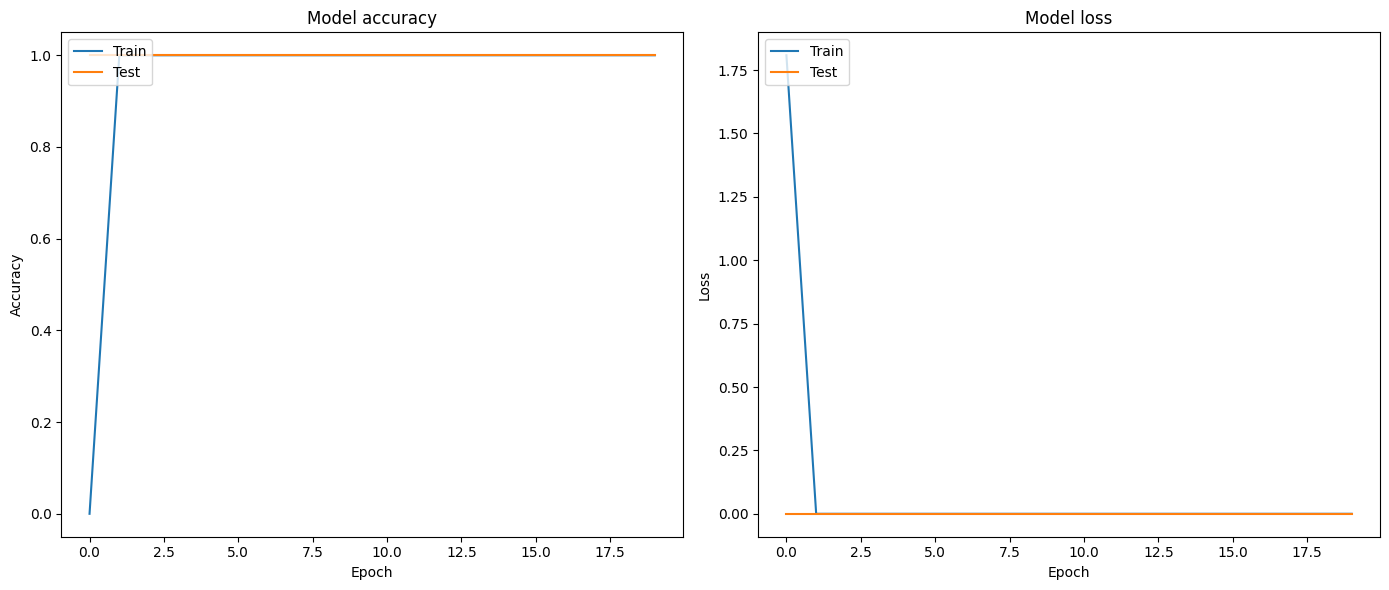

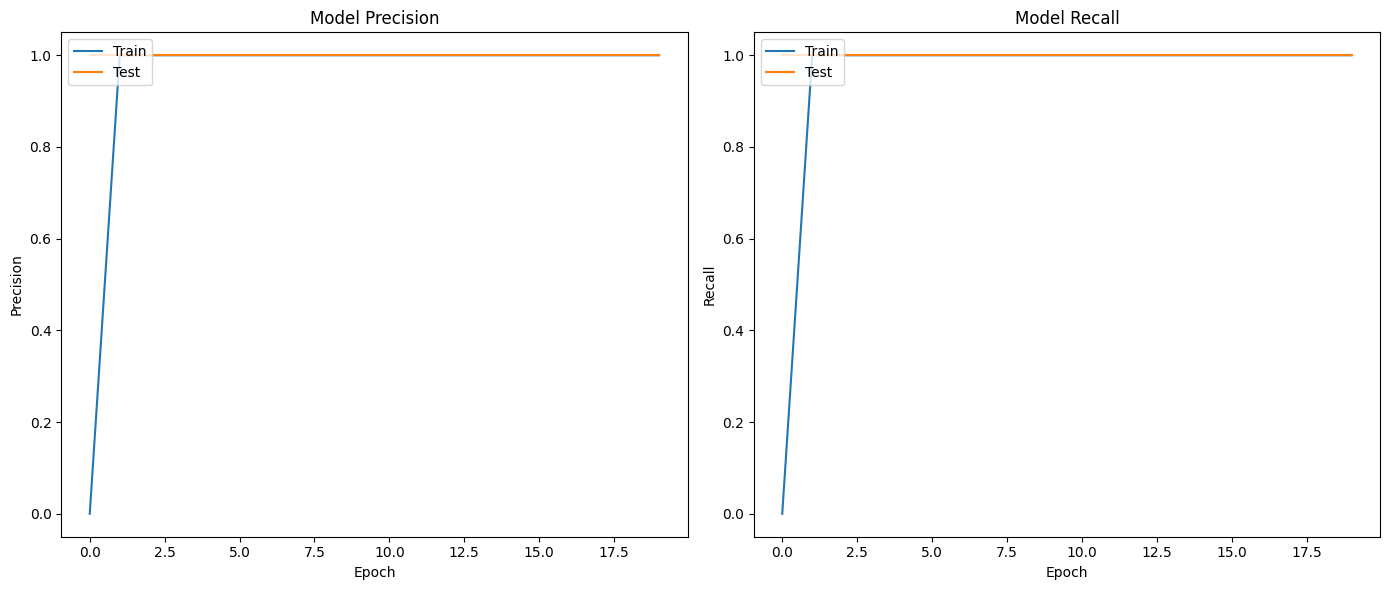

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

# Plot training & validation precision values
plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()